In [38]:
import sys
sys.path.append('../')

import pandas as pd
import tomllib as tl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import marsilea as ma
from itertools import product
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from lib import load_curvecurator

In [39]:
afatinib = {
    "name": "Afatinib",
    "id": "10184653",
    "min_threshold": 0.002,
    "max_threshold": 0.13
}

lapatinib = {
    "name": "Lapatinib",
    "id": "208908",
    "min_threshold": 0.016,
    "max_threshold": 1
}

In [40]:
def load_drugs(drug1, drug2):
    df_curvecurator1, df_doses1 = load_curvecurator(drug1['id'])
    df_curvecurator2, df_doses2 = load_curvecurator(drug2['id'])

    intersection = df_curvecurator1.index.intersection(df_curvecurator2.index)
    df_curvecurator1 = df_curvecurator1.loc[intersection]
    df_curvecurator2 = df_curvecurator2.loc[intersection]

    return df_curvecurator1, df_curvecurator2, df_doses1, df_doses2

In [41]:
def get_thresholds(drug, df_doses):
    df_doses = df_doses[(df_doses["Dose"] >= drug["min_threshold"]) & (df_doses["Dose"] <= drug["max_threshold"])]
    return df_doses["Dose"].unique()

In [42]:
afatinib_curvecurator, afatinib_doses = load_curvecurator(afatinib['id'])
lapatinib_curvecurator, lapatinib_doses = load_curvecurator(lapatinib['id'])

afatinib = afatinib | {"curvecurator": afatinib_curvecurator, "doses": afatinib_doses}
lapatinib = lapatinib | {"curvecurator": lapatinib_curvecurator, "doses": lapatinib_doses}

In [43]:
def analyze_drugs(drug1, drug2, correlation='pearson'):
    df_curvecurator1, df_curvecurator2, df_doses1, df_doses2 = load_drugs(drug1, drug2)

    thresholds1 = get_thresholds(drug1, df_doses1)
    thresholds2 = get_thresholds(drug2, df_doses2)

    combinations = defaultdict(dict)
    for threshold1, thresholds2 in product(thresholds1, thresholds2):
        drug1_columns = df_doses1[df_doses1['Dose'] == threshold1].index
        drug2_columns = df_doses2[df_doses2['Dose'] == thresholds2].index

        df1 = df_curvecurator1[drug1_columns]
        df2 = df_curvecurator2[drug2_columns]

        df_mean = pd.DataFrame(index=df1.index)
        df_mean[drug1['name']] = df1.mean(axis=1)
        df_mean[drug2['name']] = df2.mean(axis=1)

        correlation_value = df_mean.corr(correlation).iloc[0, 1]
        combinations[threshold1][thresholds2] = correlation_value
    
    df_correlation = pd.DataFrame.from_dict(combinations)
    plot = sns.heatmap(df_correlation, annot=True)
    plt.xlabel(f"{drug1['name']} Threshold")
    plt.ylabel(f"{drug2['name']} Threshold")
    plt.title(f"{drug1['name']} vs {drug2['name']} Correlation ({correlation.capitalize()})")

    return plot

<Axes: title={'center': 'Afatinib vs Lapatinib Correlation (Pearson)'}, xlabel='Afatinib Threshold', ylabel='Lapatinib Threshold'>

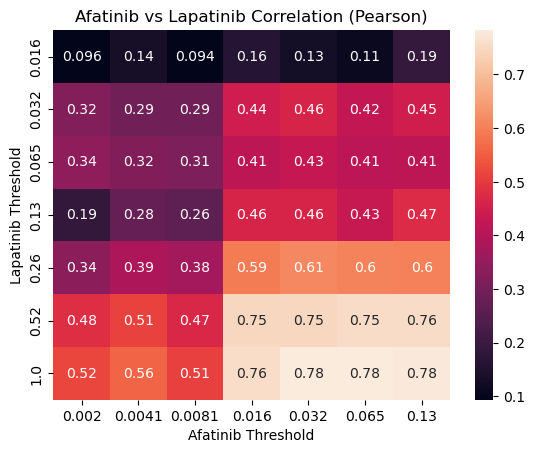

In [44]:
analyze_drugs(afatinib, lapatinib)

<Axes: title={'center': 'Afatinib vs Lapatinib Correlation (Spearman)'}, xlabel='Afatinib Threshold', ylabel='Lapatinib Threshold'>

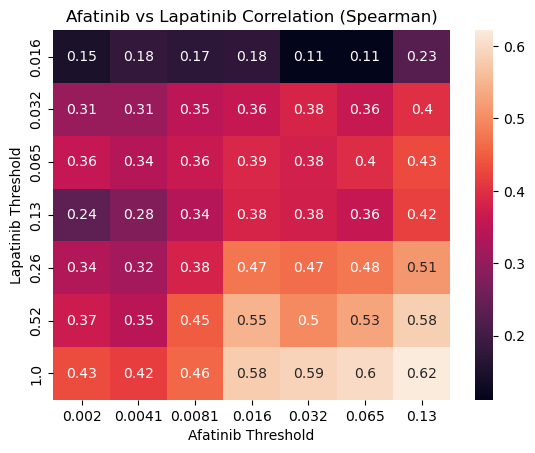

In [45]:
analyze_drugs(afatinib, lapatinib, 'spearman')

In [46]:
metrics = ["Control Ratio Std", "Signal Quality", "pEC50", "Curve Slope", "Curve Front", "Curve Back", "Curve Fold Change", "Curve AUC", "Curve RMSE", "Curve R2", "pEC50 Error", "Curve Slope Error", "Curve Front Error", "Curve Back Error", "Null Model", "Null RMSE", "Curve F_Value", "Curve P_Value", "Curve Log P_Value", "Curve F_Value SAM Corrected", "Curve Relevance Score", "Curve Regulation"]

def investigate_outliers(drug1, drug2, threshold1, threshold2):
    df_curvecurator1, df_curvecurator2, df_doses1, df_doses2 = load_drugs(drug1, drug2)

    drug1_columns = df_doses1[df_doses1['Dose'] == threshold1].index
    drug2_columns = df_doses2[df_doses2['Dose'] == threshold2].index

    df1 = df_curvecurator1[drug1_columns]
    df2 = df_curvecurator2[drug2_columns]

    df_mean = pd.DataFrame(index=df1.index)
    df_mean[drug1['name']] = 1 - df1.mean(axis=1)
    df_mean[drug2['name']] = 1 - df2.mean(axis=1)

    # Rename all columns to have drug prefix
    drug1_colmapping = {col: f"{drug1['name']}-{col}" for col in metrics}
    drug2_colmapping = {col: f"{drug2['name']}-{col}" for col in metrics}
    df_curvecurator1 = df_curvecurator1.rename(columns=drug1_colmapping)
    df_curvecurator2 = df_curvecurator2.rename(columns=drug2_colmapping)

    df_mean = pd.concat([df_mean, df_curvecurator1[list(drug1_colmapping.values())], df_curvecurator2[list(drug2_colmapping.values())]], axis=1)

    plot_dir = "outliers/"
    os.makedirs(plot_dir, exist_ok=True)

    for metric in list(drug1_colmapping.values()) + list(drug2_colmapping.values()):
        sns.scatterplot(data=df_mean, x=drug1['name'], y=drug2['name'], hue=metric)
        plt.xlabel(drug1['name'])
        plt.ylabel(drug2['name'])
        plt.title(f"{metric}")

        # Add diagonal line
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="black")

        # Regression here

        plt.savefig(f"{plot_dir}/{metric}.png")
        plt.close()
    
    return df_mean

In [47]:
df_mean = investigate_outliers(afatinib, lapatinib, 0.016, 0.52)
df_mean.head()

,Afatinib,Lapatinib,Afatinib-Control Ratio Std,Afatinib-Signal Quality,Afatinib-pEC50,Afatinib-Curve Slope,Afatinib-Curve Front,Afatinib-Curve Back,Afatinib-Curve Fold Change,Afatinib-Curve AUC,...,Lapatinib-Curve Front Error,Lapatinib-Curve Back Error,Lapatinib-Null Model,Lapatinib-Null RMSE,Lapatinib-Curve F_Value,Lapatinib-Curve P_Value,Lapatinib-Curve Log P_Value,Lapatinib-Curve F_Value SAM Corrected,Lapatinib-Curve Relevance Score,Lapatinib-Curve Regulation
Name,,,,,,,,,,,,,,,,,,,,,
CVCL_0001,0.008311,0.154993,0.0,0.0,5.535829,1.643940,1.012171,0.000100,-7.368910,0.708242,...,0.037754,0.122067,0.826884,0.203220,4.202490,1.051285e-02,1.978279,1.618970,0.628043,NaN
CVCL_0002,-0.023444,-0.084273,0.0,0.0,5.339670,4.163057,0.997704,0.007863,-6.987991,0.743762,...,0.011552,0.043562,0.969060,0.136036,39.975694,5.769794e-11,10.238840,4.028023,2.015455,down
CVCL_0004,0.007765,-0.032690,0.0,0.0,5.259911,9.569487,1.027838,0.043510,-4.522495,0.792686,...,0.013566,0.026571,0.814191,0.394607,337.216106,1.110603e-21,20.954441,46.674187,10.968653,down
CVCL_0005,0.083640,0.102006,0.0,0.0,5.478046,9.670897,0.955110,0.021940,-5.510295,0.687130,...,0.068352,0.233244,0.867308,0.245001,5.345676,2.127303e-03,2.672171,1.609276,0.638852,NaN
CVCL_0006,-0.033221,-0.040435,0.0,0.0,5.989132,1.830541,1.019038,0.051629,-4.262523,0.631778,...,0.053227,0.134701,0.898340,0.280738,5.377681,3.775780e-03,2.422993,2.058607,0.861473,NaN


In [48]:
df_mean[(df_mean["Afatinib"] > 0.15) &
        (df_mean["Afatinib"] < 0.2) &
        (df_mean["Lapatinib"] > 0.55) &
        (df_mean["Lapatinib"] < 0.7)]

,Afatinib,Lapatinib,Afatinib-Control Ratio Std,Afatinib-Signal Quality,Afatinib-pEC50,Afatinib-Curve Slope,Afatinib-Curve Front,Afatinib-Curve Back,Afatinib-Curve Fold Change,Afatinib-Curve AUC,...,Lapatinib-Curve Front Error,Lapatinib-Curve Back Error,Lapatinib-Null Model,Lapatinib-Null RMSE,Lapatinib-Curve F_Value,Lapatinib-Curve P_Value,Lapatinib-Curve Log P_Value,Lapatinib-Curve F_Value SAM Corrected,Lapatinib-Curve Relevance Score,Lapatinib-Curve Regulation
Name,,,,,,,,,,,,,,,,,,,,,
CVCL_0609,0.158639,0.55109,0.0,0.0,7.571175,4.462629,0.888175,0.287978,-1.795969,0.437784,...,0.053405,0.053252,0.613621,0.424357,99.570164,3.108629e-13,12.507431,27.798527,7.518617,down


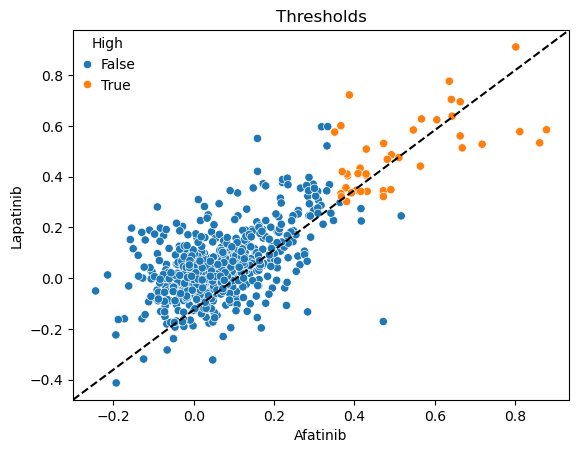

In [49]:
min_afatinib = 0.35
min_lapatinib = 0.3

df_mean["High"] = (df_mean["Afatinib"] > min_afatinib) & (df_mean["Lapatinib"] > min_lapatinib)

sns.scatterplot(data=df_mean, x=afatinib['name'], y=lapatinib['name'], hue="High")
plt.xlabel(afatinib['name'])
plt.ylabel(lapatinib['name'])
plt.title("Thresholds")

# Add diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="black")

In [50]:
plot_dir = "metrics/"
os.makedirs(plot_dir, exist_ok=True)

# Keep only numeric columns
df_mean = df_mean.select_dtypes(include='number')
metrics = df_mean.columns[2:]
df_mean["High"] = (df_mean["Afatinib"] > min_afatinib) & (df_mean["Lapatinib"] > min_lapatinib)
for metric in tqdm(metrics):
    sns.boxplot(data=df_mean, x="High", y=metric, showfliers=False)
    plt.title(metric)
    plt.savefig(f"{plot_dir}/{metric}.png")
    plt.close()

100%|██████████| 42/42 [00:03<00:00, 11.42it/s]


In [51]:
metric_pvalues = {}

for metric in tqdm(metrics):
    low = df_mean[df_mean["High"] == False][metric].values
    high = df_mean[df_mean["High"] == True][metric].values
    
    res = mannwhitneyu(low, high)
    metric_pvalues[metric] = res.pvalue

df_pvalues = pd.DataFrame.from_dict(metric_pvalues, orient='index', columns=["p-value"])
df_pvalues["p-value"] = df_pvalues["p-value"] * len(df_pvalues)
df_pvalues["significant"] = df_pvalues["p-value"] < 0.05

df_pvalues = df_pvalues.sort_values("p-value")
df_pvalues

100%|██████████| 42/42 [00:00<00:00, 732.51it/s]


,p-value,significant
Afatinib-Curve AUC,5.349960e-24,True
Afatinib-Null Model,6.992810e-24,True
Lapatinib-Curve AUC,1.372277e-22,True
Lapatinib-Null Model,5.779382e-22,True
Afatinib-pEC50,2.005567e-20,True
Lapatinib-Curve Slope Error,1.378304e-18,True
Afatinib-Null RMSE,1.430196e-18,True
Lapatinib-Curve Slope,1.861872e-16,True
Lapatinib-pEC50,6.022472e-16,True
Afatinib-Curve Slope,1.991728e-15,True


In [52]:
#def effectsize_analysis(drug):
    

_IncompleteInputError: incomplete input (1212573186.py, line 2)

In [18]:
afatinib_curvecurator.columns


Index(['N duplicates', 'Raw 0', 'Raw 1', 'Raw 2', 'Raw 3', 'Raw 4', 'Raw 5',
       'Raw 6', 'Raw 7', 'Raw 8',
       ...
       'Curve Front Error', 'Curve Back Error', 'Null Model', 'Null RMSE',
       'Curve F_Value', 'Curve P_Value', 'Curve Log P_Value',
       'Curve F_Value SAM Corrected', 'Curve Relevance Score',
       'Curve Regulation'],
      dtype='object', length=223)

In [ ]:
def cell_mapping(drug):
    mapfile = pd.read_csv("/cmnfs/proj/sysbiomed24/model_list_20240110.csv")

In [22]:
mapfile = pd.read_csv("/cmnfs/proj/sysbiomed24/model_list_20240110.csv")



0       CVCL_4897
1       CVCL_5002
2       CVCL_5064
3       CVCL_1312
4       CVCL_1873
          ...    
2150          NaN
2151          NaN
2152          NaN
2153    CVCL_V610
2154    CVCL_B3QA
Name: RRID, Length: 2155, dtype: object

In [28]:
mapping1 = dict(zip(mapfile["RRID"], mapfile["tissue"]))
mapping2 = dict(zip(mapfile["RRID"], mapfile["cancer_type"]))


In [ ]:
afatinib_curvecurator

,N duplicates,Raw 0,Raw 1,Raw 2,Raw 3,Raw 4,Raw 5,Raw 6,Raw 7,Raw 8,...,Curve Front Error,Curve Back Error,Null Model,Null RMSE,Curve F_Value,Curve P_Value,Curve Log P_Value,Curve F_Value SAM Corrected,Curve Relevance Score,Curve Regulation
Name,,,,,,,,,,,,,,,,,,,,,
CVCL_0001,1,1.0,1.0,1.0,1.0,1.0,1.0,1.014782,0.990185,NaN,...,0.016437,0.029689,0.662426,0.434105,445.531897,1.806557e-19,18.743148,140.421081,13.918133,down
CVCL_0002,1,1.0,1.0,1.0,1.0,1.0,1.0,1.162314,1.119380,NaN,...,0.018993,0.036779,0.735554,0.420147,202.545178,4.918485e-19,18.308169,82.495891,13.743720,down
CVCL_0004,1,1.0,1.0,1.0,1.0,1.0,1.0,1.095280,0.968880,NaN,...,0.007598,0.014884,0.786118,0.419171,1234.529166,1.699294e-28,27.769731,123.426229,15.770337,down
CVCL_0005,1,1.0,1.0,1.0,1.0,1.0,1.0,0.946943,0.998260,NaN,...,0.006992,0.011336,0.677049,0.421804,1618.938910,6.301648e-30,29.200546,176.037630,17.585445,down
CVCL_0006,1,1.0,1.0,1.0,1.0,1.0,1.0,1.090205,1.013615,NaN,...,0.027600,0.038588,0.637535,0.434067,156.844465,1.016623e-17,16.992840,47.462594,11.048304,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CVCL_WW69,1,1.0,1.0,1.0,1.0,1.0,1.0,1.118915,1.046658,NaN,...,0.017588,0.043105,0.788815,0.346507,138.815807,4.280667e-17,16.368489,37.130143,9.895620,down
CVCL_WW71,1,1.0,1.0,1.0,1.0,1.0,1.0,1.424840,0.218091,NaN,...,0.058543,0.295770,0.855540,0.419697,18.150447,1.710086e-07,6.766982,10.567177,4.721415,down
CVCL_WW72,1,1.0,1.0,1.0,1.0,1.0,1.0,1.013250,0.999309,NaN,...,0.017138,0.033568,0.686256,0.383996,196.727980,6.953584e-19,18.157791,73.568858,13.175960,down


In [36]:
afatinib_curvecurator["tissue"] = afatinib_curvecurator.index.map(mapping1)
afatinib_curvecurator["cancer_type"] = afatinib_curvecurator.index.map(mapping2)
afatinib_curvecurator.head()

,N duplicates,Raw 0,Raw 1,Raw 2,Raw 3,Raw 4,Raw 5,Raw 6,Raw 7,Raw 8,...,Null Model,Null RMSE,Curve F_Value,Curve P_Value,Curve Log P_Value,Curve F_Value SAM Corrected,Curve Relevance Score,Curve Regulation,tissue,cancer_type
Name,,,,,,,,,,,,,,,,,,,,,
CVCL_0001,1,1.0,1.0,1.0,1.0,1.0,1.0,1.014782,0.990185,NaN,...,0.662426,0.434105,445.531897,1.806557e-19,18.743148,140.421081,13.918133,down,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0002,1,1.0,1.0,1.0,1.0,1.0,1.0,1.162314,1.119380,NaN,...,0.735554,0.420147,202.545178,4.918485e-19,18.308169,82.495891,13.743720,down,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0004,1,1.0,1.0,1.0,1.0,1.0,1.0,1.095280,0.968880,NaN,...,0.786118,0.419171,1234.529166,1.699294e-28,27.769731,123.426229,15.770337,down,Haematopoietic and Lymphoid,Chronic Myelogenous Leukemia
CVCL_0005,1,1.0,1.0,1.0,1.0,1.0,1.0,0.946943,0.998260,NaN,...,0.677049,0.421804,1618.938910,6.301648e-30,29.200546,176.037630,17.585445,down,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0006,1,1.0,1.0,1.0,1.0,1.0,1.0,1.090205,1.013615,NaN,...,0.637535,0.434067,156.844465,1.016623e-17,16.992840,47.462594,11.048304,down,Haematopoietic and Lymphoid,Acute Myeloid Leukemia


In [68]:
pd.options.display.max_columns = None
df_mean.head()


,Afatinib,Lapatinib,Afatinib-Control Ratio Std,Afatinib-Signal Quality,Afatinib-pEC50,Afatinib-Curve Slope,Afatinib-Curve Front,Afatinib-Curve Back,Afatinib-Curve Fold Change,Afatinib-Curve AUC,Afatinib-Curve RMSE,Afatinib-Curve R2,Afatinib-pEC50 Error,Afatinib-Curve Slope Error,Afatinib-Curve Front Error,Afatinib-Curve Back Error,Afatinib-Null Model,Afatinib-Null RMSE,Afatinib-Curve F_Value,Afatinib-Curve P_Value,Afatinib-Curve Log P_Value,Afatinib-Curve F_Value SAM Corrected,Afatinib-Curve Relevance Score,Lapatinib-Control Ratio Std,Lapatinib-Signal Quality,Lapatinib-pEC50,Lapatinib-Curve Slope,Lapatinib-Curve Front,Lapatinib-Curve Back,Lapatinib-Curve Fold Change,Lapatinib-Curve AUC,Lapatinib-Curve RMSE,Lapatinib-Curve R2,Lapatinib-pEC50 Error,Lapatinib-Curve Slope Error,Lapatinib-Curve Front Error,Lapatinib-Curve Back Error,Lapatinib-Null Model,Lapatinib-Null RMSE,Lapatinib-Curve F_Value,Lapatinib-Curve P_Value,Lapatinib-Curve Log P_Value,Lapatinib-Curve F_Value SAM Corrected,Lapatinib-Curve Relevance Score,High,tissue,cancer_type
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CVCL_0001,0.008311,0.154993,0.0,0.0,5.535829,1.643940,1.012171,0.000100,-7.368910,0.708242,0.053032,0.985076,0.045706,0.213274,0.016437,0.029689,0.662426,0.434105,445.531897,1.806557e-19,18.743148,140.421081,13.918133,0.0,0.0,4.726218,10.000000,0.886693,0.530389,-0.914874,0.843658,0.159537,0.383702,0.902502,204.538387,0.037754,0.122067,0.826884,0.203220,4.202490,1.051285e-02,1.978279,1.618970,0.628043,False,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0002,-0.023444,-0.084273,0.0,0.0,5.339670,4.163057,0.997704,0.007863,-6.987991,0.743762,0.083119,0.960862,0.029706,1.314407,0.018993,0.036779,0.735554,0.420147,202.545178,4.918485e-19,18.308169,82.495891,13.743720,0.0,0.0,4.509974,10.000000,1.014066,0.566814,-0.818477,0.981448,0.056266,0.828929,0.166525,58.796449,0.011552,0.043562,0.969060,0.136036,39.975694,5.769794e-11,10.238840,4.028023,2.015455,False,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0004,0.007765,-0.032690,0.0,0.0,5.259911,9.569487,1.027838,0.043510,-4.522495,0.792686,0.034152,0.993362,0.031294,2.434655,0.007598,0.014884,0.786118,0.419171,1234.529166,1.699294e-28,27.769731,123.426229,15.770337,0.0,0.0,5.267928,10.000000,1.040079,0.122565,-3.028383,0.819261,0.060980,0.976119,0.073568,6.522988,0.013566,0.026571,0.814191,0.394607,337.216106,1.110603e-21,20.954441,46.674187,10.968653,False,Haematopoietic and Lymphoid,Chronic Myelogenous Leukemia
CVCL_0005,0.083640,0.102006,0.0,0.0,5.478046,9.670897,0.955110,0.021940,-5.510295,0.687130,0.030034,0.994930,0.034861,3.230096,0.006992,0.011336,0.677049,0.421804,1618.938910,6.301648e-30,29.200546,176.037630,17.585445,0.0,0.0,5.503226,0.819489,1.007074,0.546314,-0.782406,0.868040,0.190851,0.393189,0.749044,0.900129,0.068352,0.233244,0.867308,0.245001,5.345676,2.127303e-03,2.672171,1.609276,0.638852,False,Haematopoietic and Lymphoid,Acute Myeloid Leukemia
CVCL_0006,-0.033221,-0.040435,0.0,0.0,5.989132,1.830541,1.019038,0.051629,-4.262523,0.631778,0.097033,0.950029,0.059890,0.402161,0.027600,0.038588,0.637535,0.434067,156.844465,1.016623e-17,16.992840,47.462594,11.048304,0.0,0.0,4.776124,10.000000,1.001284,0.494178,-1.016894,0.934433,0.205823,0.462490,0.251296,389.259435,0.053227,0.134701,0.898340,0.280738,5.377681,3.775780e-03,2.422993,2.058607,0.861473,False,Haematopoietic and Lymphoid,Acute Myeloid Leukemia


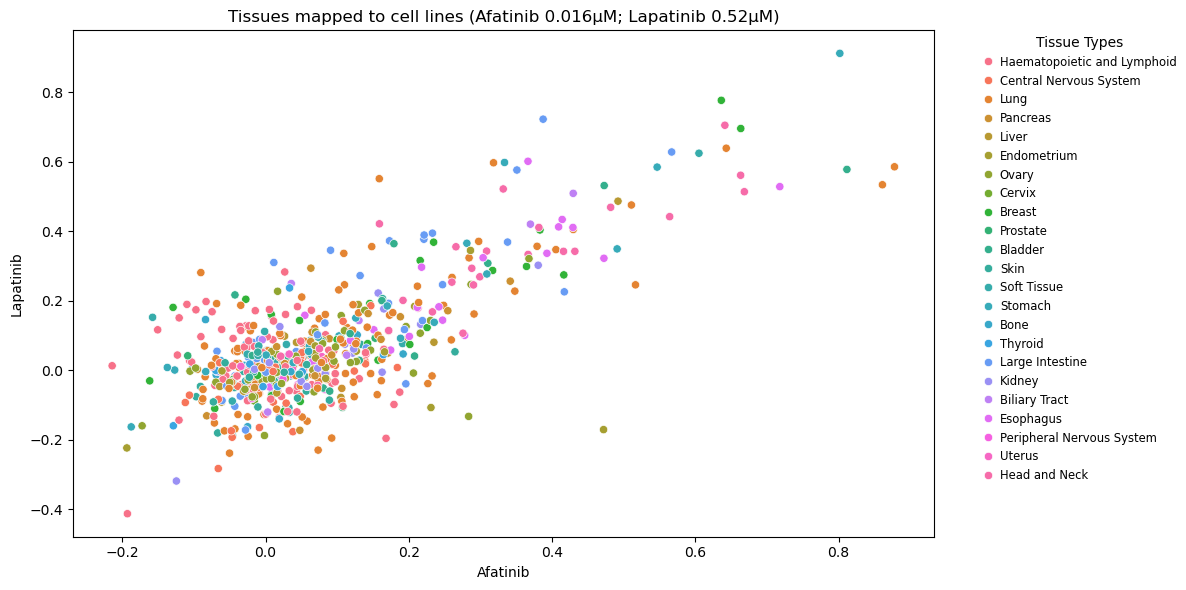

In [64]:
df_mean["tissue"] = df_mean.index.map(mapping1)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_mean, x=afatinib['name'], y=lapatinib['name'], hue = "tissue")
plt.xlabel(afatinib['name'])
plt.ylabel(lapatinib['name'])
plt.title("Tissues mapped to cell lines (Afatinib 0.016µM; Lapatinib 0.52µM)")

# Legende anpassen
plt.legend(
    title="Tissue Types",      # Titel der Legende
    bbox_to_anchor=(1.05, 1),  # Position rechts vom Plot
    loc='upper left',          # Legendenposition relativ zur Box
    fontsize='small',          # Schriftgröße der Legende
    title_fontsize='medium'    # Schriftgröße des Legendentitels
)

# Layout anpassen, damit die Legende nicht abgeschnitten wird
plt.tight_layout()

# Plot anzeigen
plt.show()

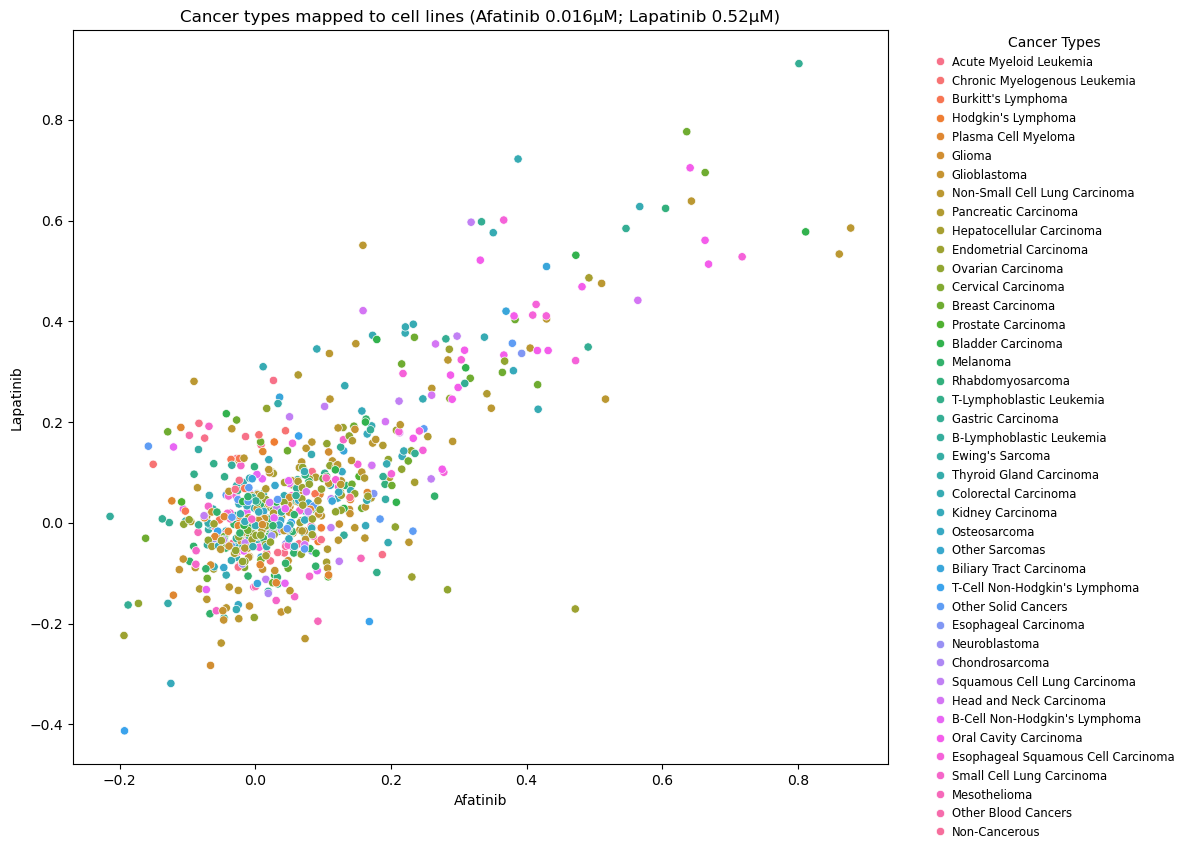

In [63]:
df_mean["cancer_type"] = df_mean.index.map(mapping2)

plt.figure(figsize=(12, 9))
sns.scatterplot(data=df_mean, x=afatinib['name'], y=lapatinib['name'], hue = "cancer_type")
plt.xlabel(afatinib['name'])
plt.ylabel(lapatinib['name'])
plt.title("Cancer types mapped to cell lines (Afatinib 0.016µM; Lapatinib 0.52µM)")

# Legende anpassen
plt.legend(
    title="Cancer Types",      # Titel der Legende
    bbox_to_anchor=(1.05, 1),  # Position rechts vom Plot
    loc='upper left',          # Legendenposition relativ zur Box
    fontsize='small',          # Schriftgröße der Legende
    title_fontsize='medium'    # Schriftgröße des Legendentitels
)

# Layout anpassen, damit die Legende nicht abgeschnitten wird
plt.tight_layout()

# Plot anzeigen
plt.show()

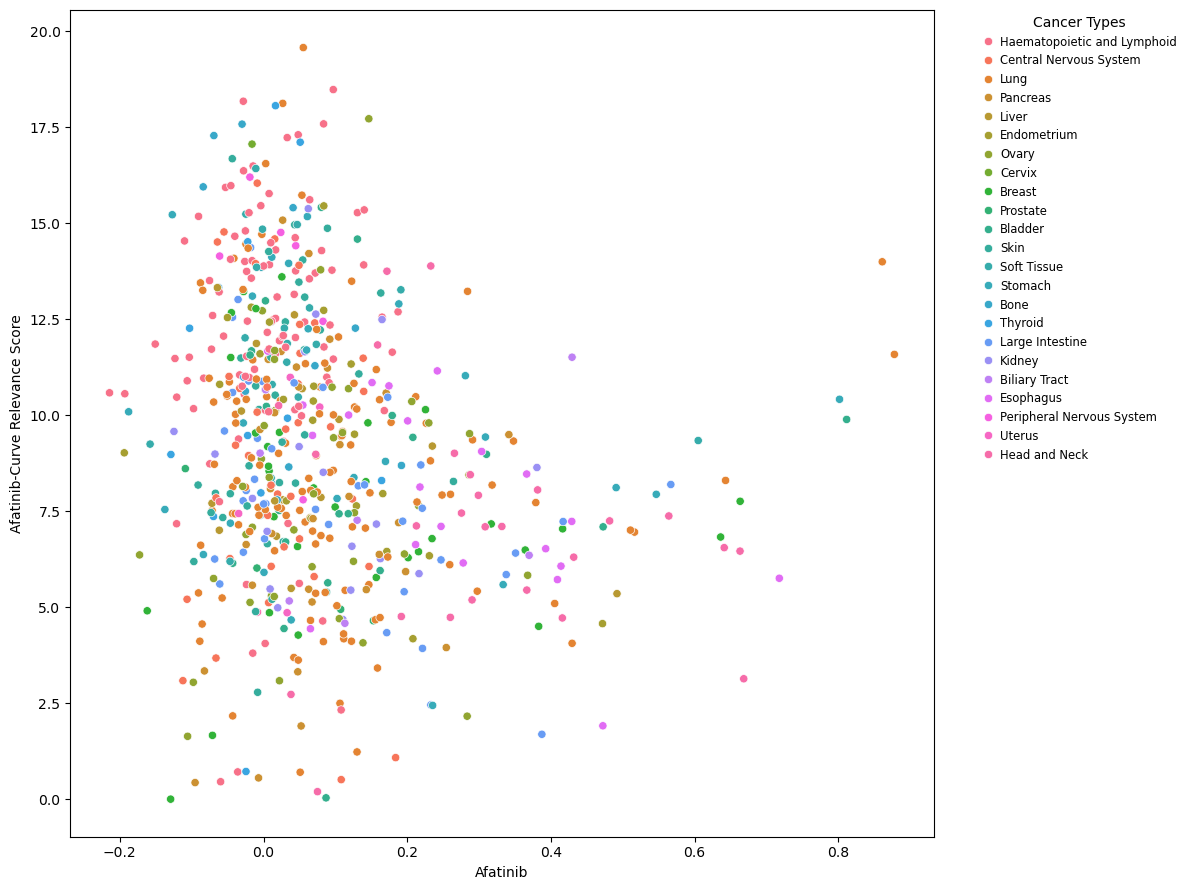

In [88]:

plt.figure(figsize=(12, 9))
sns.scatterplot(data=df_mean, x= "Afatinib", y="Afatinib-Curve Relevance Score", hue= "tissue")

# Legende anpassen
plt.legend(
    title="Cancer Types",      # Titel der Legende
    bbox_to_anchor=(1.05, 1),  # Position rechts vom Plot
    loc='upper left',          # Legendenposition relativ zur Box
    fontsize='small',          # Schriftgröße der Legende
    title_fontsize='medium'    # Schriftgröße des Legendentitels
)

# Layout anpassen, damit die Legende nicht abgeschnitten wird
plt.tight_layout()

# Plot anzeigen
plt.show()

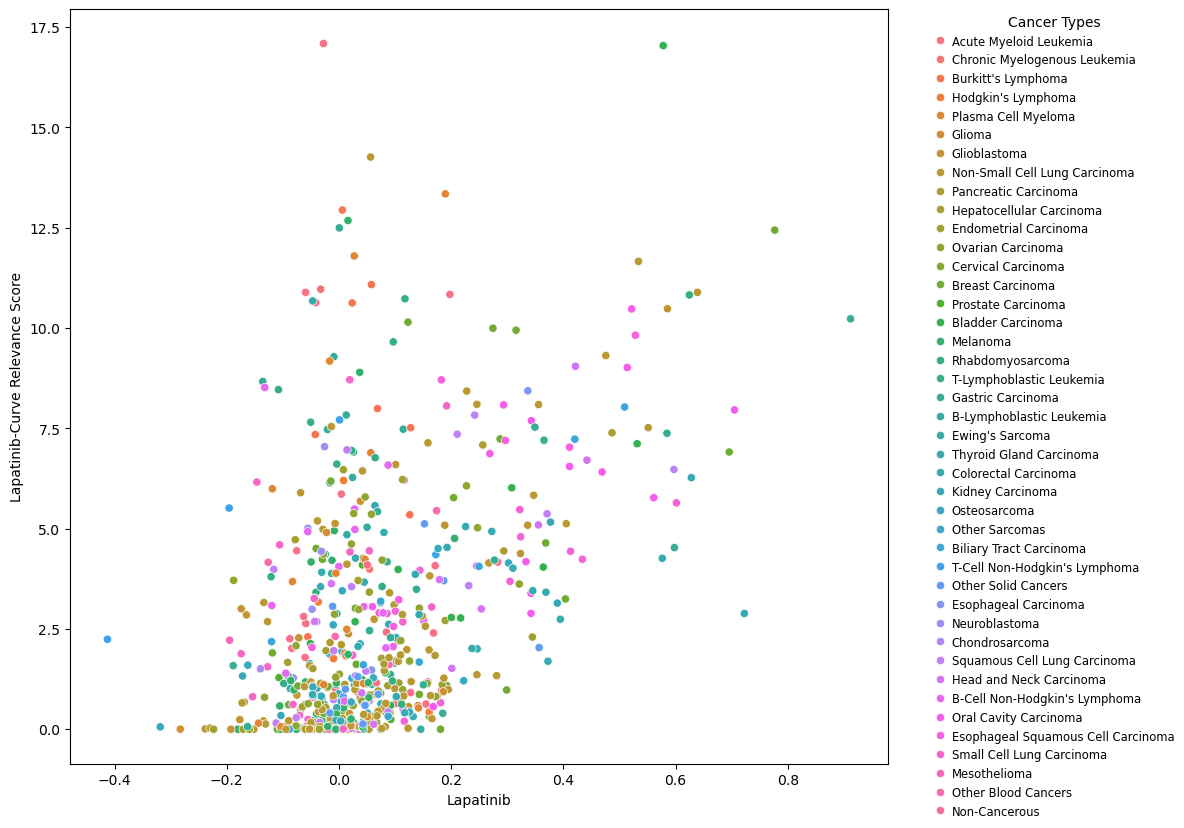

In [86]:

plt.figure(figsize=(12, 9))
sns.scatterplot(data=df_mean, x= "Lapatinib", y="Lapatinib-Curve Relevance Score", hue= "cancer_type")

# Legende anpassen
plt.legend(
    title="Cancer Types",      # Titel der Legende
    bbox_to_anchor=(1.05, 1),  # Position rechts vom Plot
    loc='upper left',          # Legendenposition relativ zur Box
    fontsize='small',          # Schriftgröße der Legende
    title_fontsize='medium'    # Schriftgröße des Legendentitels
)

# Layout anpassen, damit die Legende nicht abgeschnitten wird
plt.tight_layout()

# Plot anzeigen
plt.show()

In [74]:
df_mean[['Afatinib','Afatinib-Curve Relevance Score']]

,Afatinib,Afatinib-Curve Relevance Score
Name,,
CVCL_0001,0.008311,13.918133
CVCL_0002,-0.023444,13.743720
CVCL_0004,0.007765,15.770337
CVCL_0005,0.083640,17.585445
CVCL_0006,-0.033221,11.048304
...,...,...
CVCL_WW68,0.036554,11.952509
CVCL_WW69,0.052072,9.895620
CVCL_WW71,-0.244325,4.721415
